# Doing Bayesian Data Analysis
### Examples from John Krushcke's R/JAGS book worked in Python/PyMC
John Kruschke's [book](http://www.amazon.com/Doing-Bayesian-Analysis-Second-Edition/dp/0124058884) is excellent! However all the examples are in R and JAGS. I'll work through a couple introductory examples below using Python and the excellent [PyMC package](https://github.com/pymc-devs/pymc). For a more exhaustive translation of all the book's programs in Python, check out Osvaldo Martin's [github repository](https://github.com/aloctavodia/Doing_bayesian_data_analysis).

In [1]:
# importing all necessary packages
import numpy as np
import pymc
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pydot
import seaborn as sns

# setting matplotlib's style
# plt.style.use('seaborn-whitegrid')

Couldn't import dot_parser, loading of dot files will not be possible.


# 1. Coin Flips

We suppose that a series of $N$ coin flips/clinical experiments/any other application with two outcomes (heads or tails) has a probability of success $p_i$ for coin flip $i$. Each experiment therefore follows a Bernoulli distribution and the probability that the outcome is $y, y \in \{0,1\}$ is:
$$p_i (y) = p^y (1-p)^{1-y}$$

Our goal here is to find, using Bayesian statistics, the distribution of the parameter $p$ given the results of $N$ experimental data points. We'll start by generating fake data:

In [2]:
n_trials = 50
true_p = 0.3
coin_flip_data = np.random.rand(n_trials) < true_p

In [3]:
coin_flip_data

array([False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False,  True, False, False, False,  True, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True], dtype=bool)

Now that we have the results of our experiment, we need to specify our *prior*. The prior is the distribution of the value of $p$ before the experiment, according to our beliefs. Since we don't know anything about $p$, we'll choose a Beta distribution with both parameters equal to 1, which is essentially a flat distribution reflecting no prior knowledge.  

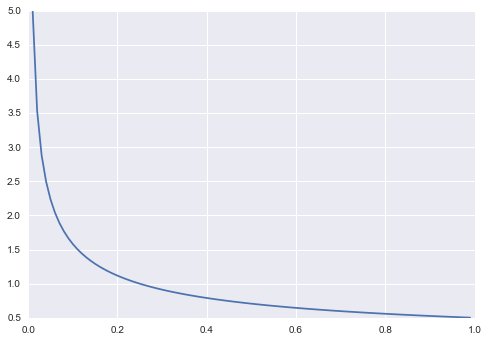

In [4]:
p = pymc.distributions.Beta("p", alpha=1, beta=1)
beta_like_vectorized = np.vectorize(pymc.distributions.beta_like)
params = np.arange(0.01,1,.01)
plt.plot(params, np.exp(beta_like_vectorized(params, alpha=.5, beta=1)))

Note that we give a name to the Beta parameter. PyMC, when building the model, uses that name to link all our definitions together, so that "p" is important. Let's move on to the second building block of our model, the Bernoulli-distributed data. In the same way, we tell PyMC that this is a random variable, but also tell it that we have observed it, and pass it the values.

In [5]:
coin_flip = pymc.distributions.Bernoulli("coin_flip", p=p, value=coin_flip_data, observed=True)

We then define our model, and we are done!

In [6]:
model = pymc.MCMC([coin_flip,p])

Let's look at what PyMC did for us behind the scenes:

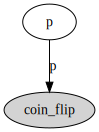

In [35]:
graph = pymc.graph.graph(model) # we're only asking for a graph of our model
from IPython.display import display_svg # to display the SVG inline
display_svg(graph.create_svg(),raw = True)

Looks good! We specified our model, and we're displaying a *very* simple graph that shows that both `p` and `coin_flip` are random variables (they are displayed as ellipses) and that `coin_flip` is observed (grey shading). Now that the model is specified, let's run the MCMC. 

In [8]:
model.sample(iter=10000, burn=100)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.5 sec

The MC has been run! We can now access the distribution for our parameter of interest, $p$, plot its distribution, its 95% HDI, find its mean, etc... PyMC nicely does this for us:

In [9]:
model.stats()

{'p': {'95% HPD interval': array([ 0.1088742 ,  0.32369438]),
  'mc error': 0.0015621205258210878,
  'mean': 0.21196468413361083,
  'n': 9900,
  'quantiles': {2.5: 0.11166779308354416,
   25: 0.17343024405167229,
   50: 0.20819876757630906,
   75: 0.2489680794604629,
   97.5: 0.328877129918836},
  'standard deviation': 0.056133761187689354}}

Plotting p


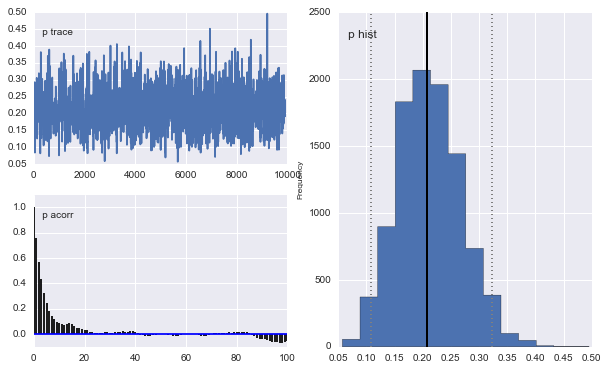

In [10]:
pymc.Matplot.plot(model)

That's all there is to it! PyMC gives us summary statistics, a couple plots to check that everything looks good, and we're done. Let's move on to something a little more complicated.

# 2. Hierarchical Models

This example is slightly more complicated. The data is real and the description for the experiment can be found in the book. The gist of it is that instead of one coin, we have 28 different type of coins, produced by the same factory, and 10 throws per coin. We're interested in the distribution of:
- the bias of the factory
- the bias of each coin.
Let's start by importing the data and slightly manipulating it with pandas:

In [11]:
DF = pd.read_csv("./data/TherapeuticTouchData.csv")
DF['s']=DF['s'].astype('category') # we tell pandas that column "s" represent a category. Here, the 'type' of coin
DF['s']=DF['s'].cat.codes # and we convert the category to numbers, for convenience

In this data, `y` represents the result of the experiment, and `s` is the number identifying the coin.

In [12]:
DF.head() 

,y,s
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0


In [13]:
number_of_subjects = DF.s.unique().size

We now need to specify the model, parametrically. We first specify a beta distribution for the mean bias at factory level, centered on 0.5. We assume that the factory will tend to produce fair coins!

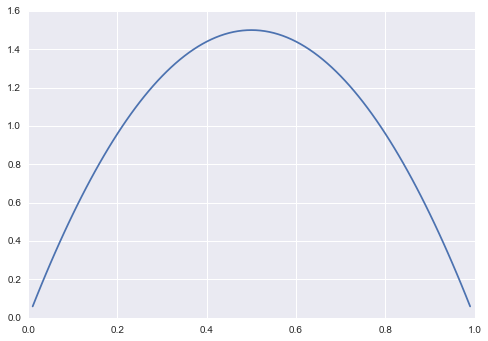

In [14]:
factory_mean = pymc.distributions.Beta("factory_mean", alpha=2, beta=2)
beta_like_vectorized = np.vectorize(pymc.distributions.beta_like)
plt.plot(params, np.exp(beta_like_vectorized(params, alpha=2, beta=2)))

Now we need to express how "sure" we are of this prior. This is done by specifiying a random "sample size", that peaks at 0 and whose mean is relatively low. The author chose a Gamma distribution with a sample size of 10 as its mean, $\alpha/\beta = 10$.

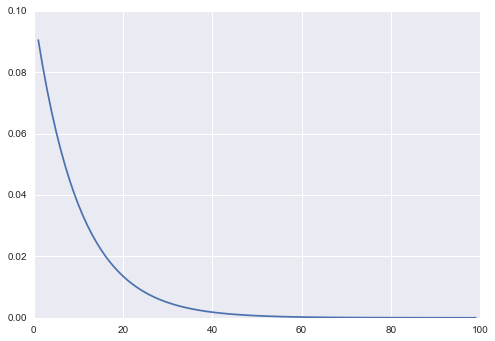

In [15]:
sample_size = pymc.distributions.Gamma("sample_size", alpha=1, beta=0.1)
gamma_like_vectorized = np.vectorize(pymc.distributions.gamma_like)
plt.plot(params*100, np.exp(gamma_like_vectorized(params*100, alpha=1, beta=0.1)))

We then draw the biases for each coin (hence `size = number_of_subjects`) from a beta distribution with the stochastic sample size and mean defined before:

In [16]:
theta_s = pymc.distributions.Beta("theta_s",alpha=sample_size*factory_mean,
                                  beta=(1-factory_mean)*sample_size,size = number_of_subjects)

Last step: we tell PyMC that the data follows a Bernoulli distribution, with the bias for each coin following the beta distribution we specified above


In [17]:
experiment_success = pymc.distributions.Bernoulli("experiment_success", p=theta_s[DF.s], value=DF.y, observed=True)

In [18]:
HierarchicalModel = pymc.MCMC([experiment_success, theta_s, sample_size, factory_mean])

In [31]:
graph_hierarchical = pymc.graph.graph(HierarchicalModel) # we're only asking for a graph of our model
display_png(graph_hierarchical.create_png(),raw = True)

NameError: name 'display_png' is not defined

Ok so the graph is too big to be visualized nicely, but you can scroll around and see that it works fine. Time to run the model.

In [20]:
HierarchicalModel.sample(iter=200000, burn=5000,thin =20)

 [-----------------100%-----------------] 200000 of 200000 complete in 37.0 sec

Plotting factory_mean
Plotting sample_size


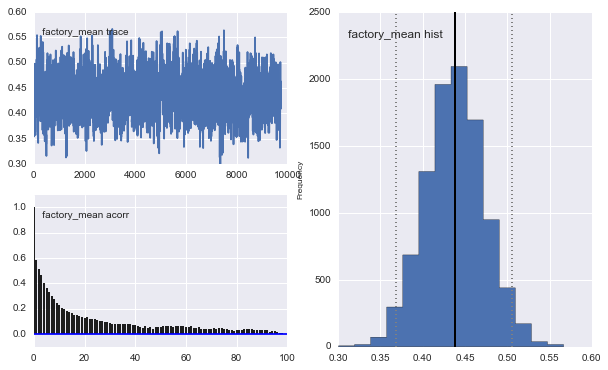

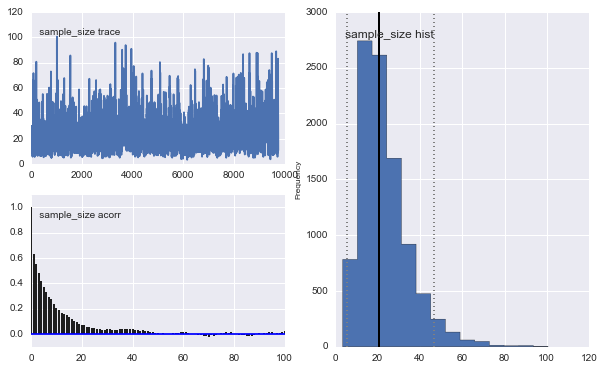

In [21]:
pymc.Matplot.plot(HierarchicalModel)

In [22]:
HierarchicalModel.stats()

{'factory_mean': {'95% HPD interval': array([ 0.36829015,  0.50613556]),
  'mc error': 0.0013641808795208056,
  'mean': 0.4382282415490798,
  'n': 9750,
  'quantiles': {2.5: 0.36939785907658651,
   25: 0.41510653933355868,
   50: 0.43814425674517271,
   75: 0.46084654817260334,
   97.5: 0.5077631731228528},
  'standard deviation': 0.035078652496654997},
 'sample_size': {'95% HPD interval': array([  5.7063779 ,  46.53946496]),
  'mc error': 0.41508469073933629,
  'mean': 23.1681323524516,
  'n': 9750,
  'quantiles': {2.5: 7.8641844907934182,
   25: 14.778189136584267,
   50: 20.642943194314483,
   75: 28.673780577385784,
   97.5: 53.746825077267069},
  'standard deviation': 11.84989591237747},
 'theta_s': {'95% HPD interval': array([[ 0.13201273,  0.17768136,  0.21555859,  0.21723391,  0.20389994,
           0.2083393 ,  0.21363823,  0.21652291,  0.22442682,  0.21264405,
           0.24470476,  0.23929764,  0.24153227,  0.23701133,  0.24433804,
           0.28553437,  0.26622362,  0.273

Ok, so the output from PyMC is not as nice for so many parameters. Let's try to represent this data in a nicer way, starting with a little dataframe rearranging:

In [36]:
traceDF=pd.DataFrame(HierarchicalModel.trace("theta_s")[:,:])
traceDF = traceDF.stack().reset_index()
traceDF.columns = ["experiment","coin","value"]

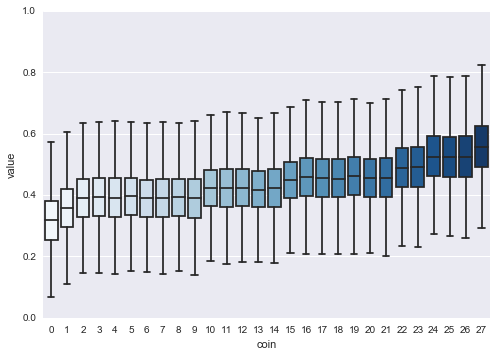

In [38]:
sns.boxplot(x = "coin", y = "value", data = traceDF,fliersize = 0, palette = 'Blues')

We can clearly see in the boxplot representation that none of the coins are significantly biased - the HDI intervals all include 0.5. We can also explore the distribution of differences between each of the variables; typically $\theta_0 - \theta_{27}$, since they seem to be the most different.

In [27]:
diff = traceDF.value[traceDF.coin == 0]- traceDF.value[traceDF.coin == 27]

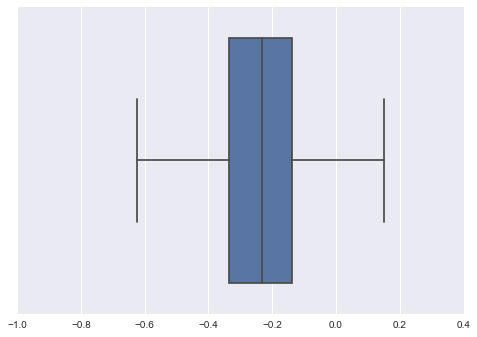

In [42]:
sns.boxplot(np.array(traceDF.value[traceDF.coin == 0])-np.array(traceDF.value[traceDF.coin == 27]),fliersize = 0)

Here again, the difference between 0 and 27 is not significant, as it is in the 95% HDI (tough not to write confidence interval after years and years of frequentism :)